In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Extract labels

In [2]:
fn = 'F:\\Github\\radar_HAR\\Dataset_848\\1 December 2017 Dataset\\1P36A01R01.dat'

The data files have been named with this generic approach KPXXAYYRZ so that
* the digits K 1 2 3 4 5 and 6 at the beginning indicates the activities walking, sitting down, stand up, pick up
an object, drink water, and fall respectively; 1P36A01R01对应的是1，所以是walking；
* the characters XX indicate the subject (individual person) having ID XX (01, 02, etc…); 1P36A01R01对应的是36号参与者；
* the characters YY indicate the activity being performed such as A01, A02, A03, A04, A05, and A06;1P36A01R01对应的是A01；
* the character Z indicates the repetition of the activity such as R1, R2, etc. 1P36A01R01对应的是R01，重复第1次，后面还有R02，R03，因此一组动作重复做3次。

In [3]:
fn.split('\\')

['F:',
 'Github',
 'radar_HAR',
 'Dataset_848',
 '1 December 2017 Dataset',
 '1P36A01R01.dat']

In [4]:
fn.split('\\')[-1].split('.')[0]

'1P36A01R01'

In [5]:
labels = fn.split('\\')[-1].split('.')[0]

In [6]:
int(labels[0])

1

In [7]:
int(labels[2:4])

36

In [8]:
def extract_labels(fn):
    labels = fn.split('\\')[-1].split('.')[0]
    activity = int(labels[0])
    person = int(labels[2:4])
    return activity, person

In [9]:
activity, person = extract_labels(fn)

In [10]:
activity

1

In [11]:
person

36

# Extract features

In [55]:
import pandas as pd

In [56]:
radar_df = pd.read_table(fn, sep="\n", header=None)

In [57]:
radar_df.head()

,0
0,5800000000.000000
1,1.000000
2,128
3,400000000.000000
4,1812+1897i


In [58]:
radar_df.shape

(1280004, 1)

In [59]:
type(radar_df[0][5])

str

In [60]:
radar_df.head()

,0
0,5800000000.000000
1,1.000000
2,128
3,400000000.000000
4,1812+1897i


In [61]:
center_frequency = float(radar_df[0][0])  # the carrier frequency 5.8 GHz
sweep_time = float(radar_df[0][1])/1000  # convert to seconds (0.001 seconds)
number_of_time_samples = float(radar_df[0][2])  # 128
bandwidth = float(radar_df[0][3])  # 400000000Hz (400 MHz)
sampling_frequency = number_of_time_samples / sweep_time
'''
record length (in seconds) = (number of measurements / 128 time samples) * sweep time of 1ms
'''
record_length = (len(radar_df[0][4:]) / number_of_time_samples) * sweep_time
number_of_chirps = record_length / sweep_time  # 单分量线性调频信号的个数

In [62]:
record_length

10.0

In [63]:
number_of_chirps

10000.0

对于每一个输入的数值，自定义一个函数来进行数值的转化：

In [64]:
def to_complex(sample_str):
    sample_str = sample_str.replace('i', 'j')
    return complex(sample_str)

In [65]:
to_complex(radar_df[0][4])

(1812+1897j)

把所有的数据都转换过来：

In [66]:
data = radar_df[0][4:].apply(to_complex).values

In [67]:
data

array([1812.+1897.j, 1782.+2029.j, 2265.+2014.j, ..., 2111.+2147.j,
       2058.+2187.j, 2004.+2183.j])

In [68]:
data.shape

(1280000,)

Convert the raw measurments into a matrix with a column per chirp.

In [69]:
number_of_chirps

10000.0

In [70]:
number_of_time_samples

128.0

In [71]:
# Reshape into chirps over time
import numpy as np
data_time = np.reshape(data, (int(number_of_chirps), int(number_of_time_samples)))
data_time = np.rot90(data_time)

In [72]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['font.size'] = 20

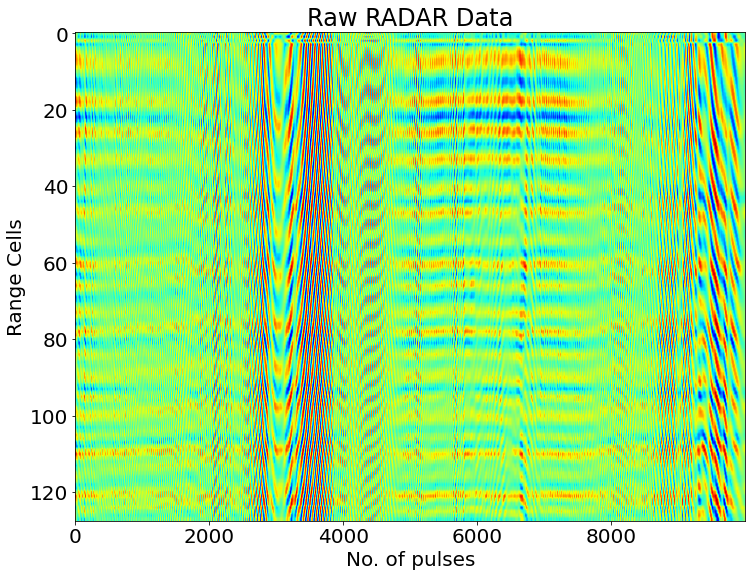

In [73]:
# flip upside down to get range cell axis to be correct
plt.figure(figsize=[12, 9])
plt.imshow(np.flipud(abs(data_time)), cmap='jet', aspect="auto")
plt.title("Raw RADAR Data")
plt.xlabel("No. of pulses")
plt.ylabel("Range Cells")
# plt.show()
plt.savefig('range-pulse.png', dpi=400, bbox_inches='tight')

Apply a FFT along each chirp to compute the range profiles.

In [74]:
win = np.ones((int(number_of_time_samples), data_time.shape[1]))
win = np.ones(data_time.shape)

In [75]:
# Apply fast fourier transform which should compute distance (range) from objects
fft_applied = np.fft.fftshift(np.fft.fft((data_time * win), axis=0), 0)

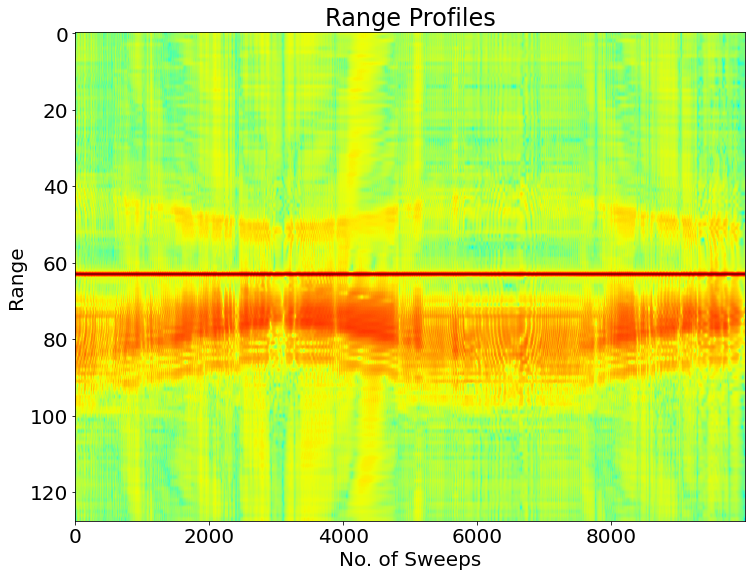

In [76]:
plt.figure(figsize=[12, 9])
plt.imshow(20 * np.log10(np.flipud(abs(fft_applied))), cmap='jet', aspect="auto")
plt.title("Range Profiles")
plt.xlabel("No. of Sweeps")
plt.ylabel("Range")
plt.show()


In [77]:
data_range = fft_applied[1:int(number_of_time_samples/2), :] 

In [78]:
data_range.shape

(63, 10000)

In [79]:
tmp = np.rot90(data_range, -1)

In [80]:
tmp[0][0]

(-835.4027109626746+2035.936317434817j)

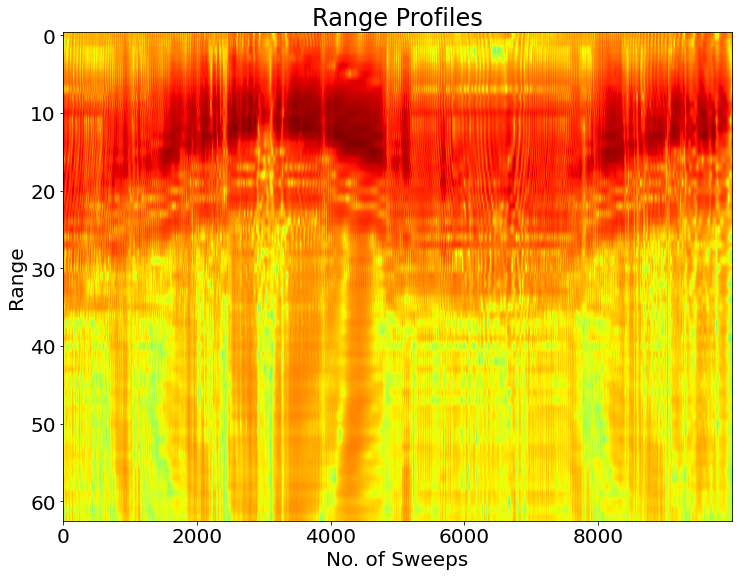

In [81]:
plt.figure(figsize=[12, 9])
plt.imshow(20 * np.log10(np.flipud(abs(data_range))), cmap='jet', aspect="auto")
plt.title("Range Profiles")
plt.xlabel("No. of Sweeps")
plt.ylabel("Range")
# plt.show()
plt.savefig('sweep-range.png', dpi=400, bbox_inches='tight')

In [82]:
x = data_range.shape[1]

# set ns to nearest even number to x
if x % 2 == 0:
    ns = x
else:
    ns = x - 1

In [83]:
from scipy.signal import butter, lfilter

In [84]:
data_range_MTI = np.zeros((data_range.shape[0], ns), dtype=np.complex128)

In [85]:
(b, a) = butter(4, 0.0075, btype="high")  # 高通滤波器 high-pass Butterworth notch filter

In [86]:
b

array([ 0.96968306, -3.87873226,  5.81809838, -3.87873226,  0.96968306])

In [87]:
a

array([ 1.        , -3.93843036,  5.81717942, -3.819034  ,  0.94028524])

Numerator (b) and denominator (a) polynomials of the filter. 

In [88]:
# Apply Filter
for i in range(data_range.shape[0]):
    data_range_MTI[i, :ns] = lfilter(b, a, data_range[i, :ns], axis=0)

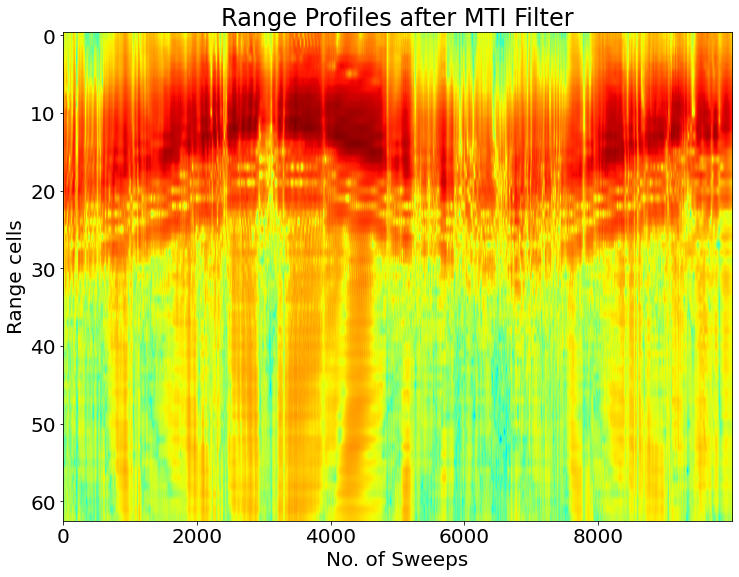

In [89]:
plt.figure(figsize=[12, 9])
plt.imshow(20*(np.log10(np.flipud(abs(data_range_MTI)))), cmap='jet', aspect="auto")
plt.title("Range Profiles after MTI Filter")
plt.xlabel("No. of Sweeps")
plt.ylabel("Range cells")
plt.savefig('sweep-range-after-MTI-filter.png', dpi=400, bbox_inches='tight')

In [90]:
# Selects range bins
bin_indl = 10
bin_indu = 30

time_window_length = 200
overlap_factor = 0.95
overlap_length = np.round(time_window_length * overlap_factor)
pad_factor = 4
fft_points = pad_factor * time_window_length

prf = 1/sweep_time
doppler_bin = prf / fft_points
doppler_axis = np.arange(-prf / 2, prf / 2 - doppler_bin + 1, doppler_bin)
whole_duration = data_range_MTI.shape[1] / prf
num_segments = np.floor((data_range_MTI.shape[1] - time_window_length) /
    (np.floor(time_window_length * (1 - overlap_factor))))

In [91]:
from matplotlib import mlab
from matplotlib import colors

In [92]:
data_spec_MTI=0
for rbin in range(bin_indl-1, bin_indu):
    s, f, t = mlab.specgram(data_range_MTI[rbin, :],
                            Fs=1,
                            window=np.hamming(time_window_length),
                            noverlap=overlap_length,
                            NFFT=time_window_length, 
                            mode='complex',
                            pad_to=fft_points )

    data_spec_MTI = data_spec_MTI+abs(s)    

In [93]:
time_axis = np.linspace(0, whole_duration, data_spec_MTI.shape[1])

In [94]:
data_spec_MTI.shape

(800, 981)

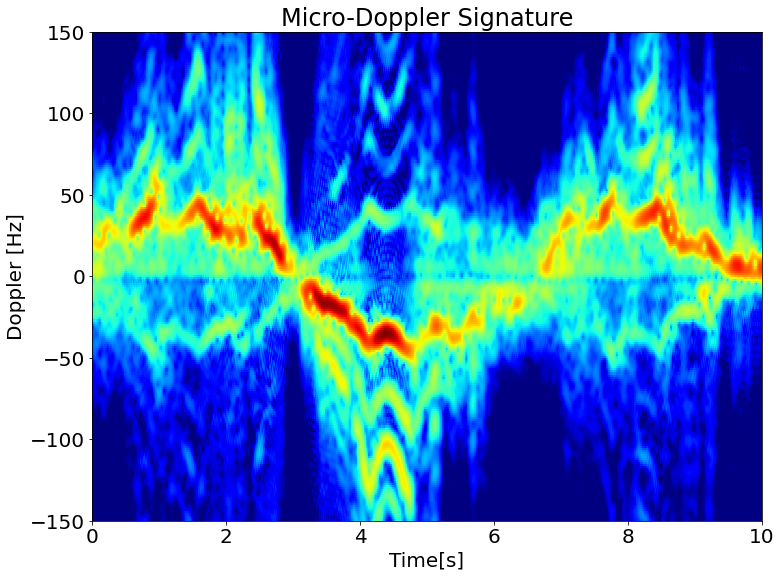

In [95]:
minimum_value = 35
norm = colors.Normalize(vmin=minimum_value, vmax=None, clip=True)
plt.figure(figsize=[12, 9])
plt.pcolormesh(time_axis, doppler_axis, 20 * np.log10(np.flipud(np.abs(data_spec_MTI))), cmap='jet', rasterized=True, norm=norm)
plt.ylim([-150, 150])
plt.title("Micro-Doppler Signature")
plt.xlabel("Time[s]")
plt.ylabel("Doppler [Hz]")
# plt.show()
plt.savefig('Micro-Doppler Signature.png', dpi=400, bbox_inches='tight')

通过频率与速度之间的转化关系 v = f * 光速/(2 * 载波频率) 画成了纵轴为速度的图。